In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt

sys.path.insert(1, '../src')
from backtest import Backtest
from optimization import *
from constraints import Constraints

import quantstats as qs
qs.extend_pandas()

In [2]:
path = '../data/'  # Change this to your path

# Prepare data
return_series = pd.read_parquet(f'{path}usa_returns.parquet')
return_series_index = pd.read_csv(f'{path}SPTR.csv', index_col = 0)
return_series_index.index = pd.to_datetime(return_series_index.index, format='%d/%m/%Y')
features = pd.read_parquet(f'{path}usa_features.parquet')
data = {'return_series': return_series,
        'return_series_index': return_series_index,
        'features': features}

# Define rebalancing dates
n_days = 21
start_date = '2023-01-01'
dates = data['return_series'].index
rebdates = dates[dates > start_date][::n_days].strftime('%Y-%m-%d').tolist()
width = 252

# Define constraints
constraints = Constraints(selection = data['return_series'].columns)
constraints.add_budget()
constraints.add_box(box_type = 'LongOnly')

# Define optimization
optimization = LeastSquares(solver_name = 'cvxopt')
optimization.constraints = constraints

# Initialize backtest object
bt = Backtest(rebdates = rebdates, width = width)
bt.data = data
bt.optimization = optimization

# Run backtest
bt.run()

# Simulation
sim_bt = bt.strategy.simulate(return_series = bt.data['return_series'],
                            fc = 0,
                            vc = 0)

Rebalancing date: 2023-01-03
Rebalancing date: 2023-02-02
Rebalancing date: 2023-03-06
Rebalancing date: 2023-04-04
Rebalancing date: 2023-05-04
Rebalancing date: 2023-06-05
Rebalancing date: 2023-07-06
Rebalancing date: 2023-08-04
Rebalancing date: 2023-09-05
Rebalancing date: 2023-10-04
Rebalancing date: 2023-11-02
Rebalancing date: 2023-12-04
Rebalancing date: 2024-01-04


2023-01-03    141
2023-02-02    142
2023-03-06    152
2023-04-04    152
2023-05-04    167
2023-06-05    149
2023-07-06     29
2023-08-04     27
2023-09-05     21
2023-10-04     28
2023-11-02     25
2023-12-04     35
2024-01-04     33
dtype: int64


{'Sharpe': 1.4609621141496187, 'VaR': -0.011799548479729175}

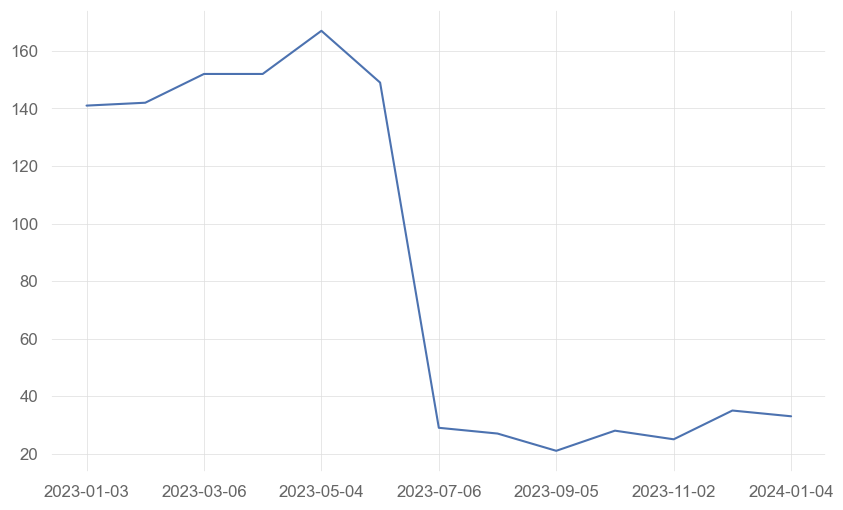

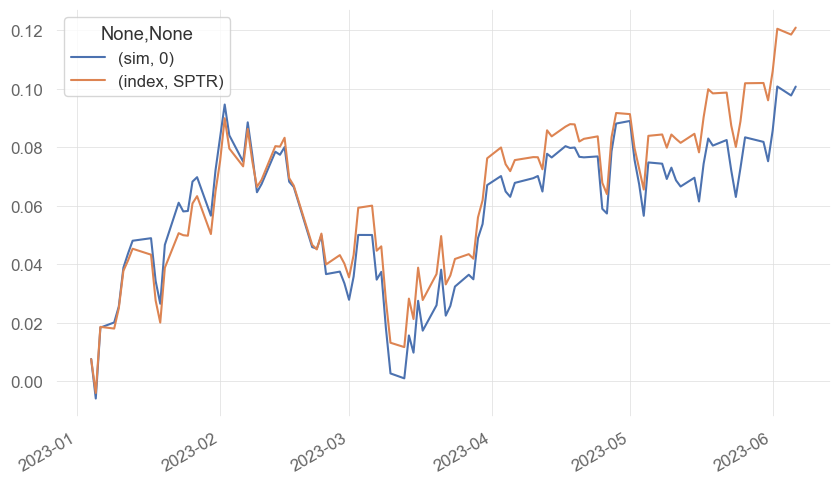

In [3]:
# Analyze weights
bt.strategy.get_weights_df()
print(bt.strategy.number_of_assets())
bt.strategy.number_of_assets().plot()


# Analyze simulation
sim = pd.concat({'sim': sim_bt,
                'index': bt.data['return_series_index']}, axis = 1).dropna()
sim = np.log(1 + sim).cumsum().plot()

# Performance metrics
report = {'Sharpe' : sim_bt.sharpe(),
          'VaR' : sim_bt.value_at_risk()}
report

In [4]:
Xs = []
ys = []
for rebdate in rebdates:
    X = data['return_series']
    y = data['return_series_index']
    Xs.append(X[X.index <= rebdate].tail(width+1).to_numpy())
    ys.append(y[y.index <= rebdate].tail(width+1).to_numpy())

In [5]:
# last date 2023-06-06 -> drop of # assets 2023-07
data['return_series_index'].tail(5)

,SPTR
2023-05-31,-0.005901
2023-06-01,0.010038
2023-06-02,0.014593
2023-06-05,-0.001986
2023-06-06,0.002380


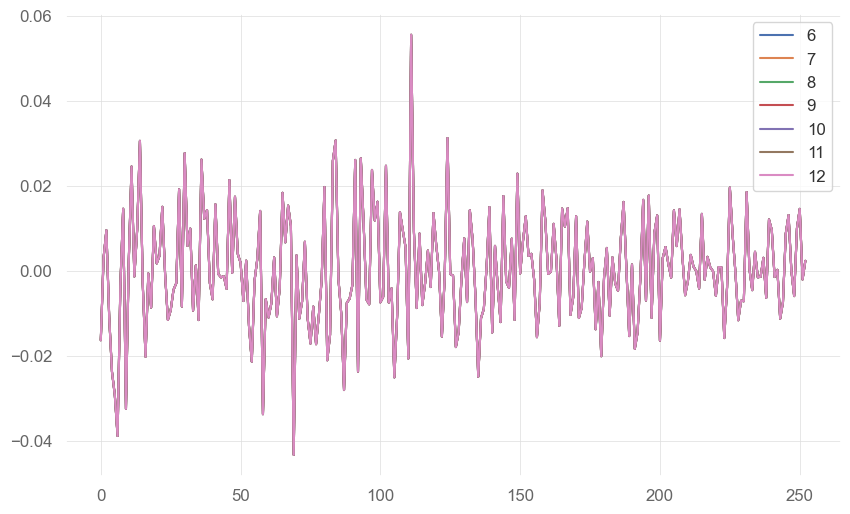

In [6]:
# constant y -> constant q
for i in range(6, len(Xs)):
    X = bt.summary[i]['X']
    y = bt.summary[i]['y']
    plt.plot(ys[i], label=str(i))
plt.legend()
plt.show()

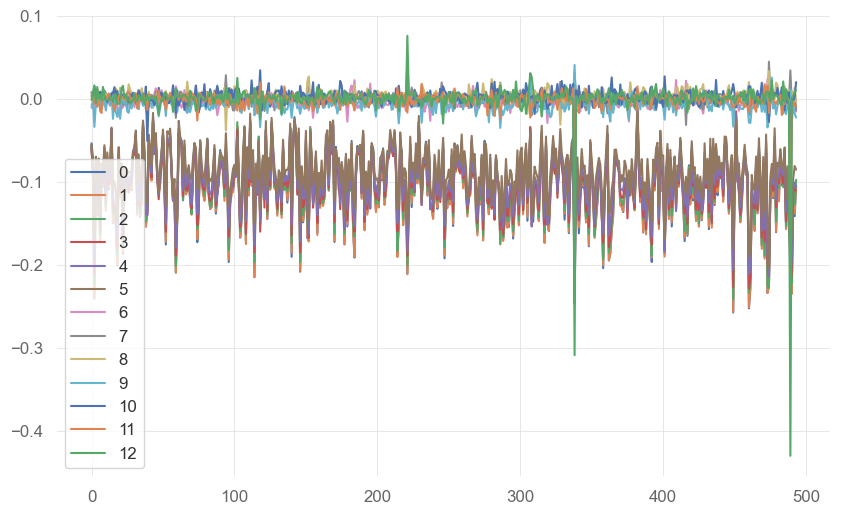

In [39]:
for i in range(len(bt.summary)):
    plt.plot(bt.summary[i]['q'], label =str(i))
plt.legend()
plt.show()